In [55]:

from nltk.corpus import wordnet as wn
import numpy as np
import pandas as pd
import wikipedia
from urllib.request import urlopen
import json
import re
api = "https://www.googleapis.com/books/v1/volumes?q=title:"
isbnAPI = "https://www.googleapis.com/books/v1/volumes?q=isbn:"


## Big idea- Using wikipedia pages to infer ethnicity
Keywords and permulations
- taking the associated catagories that are used, and using nltk's wordnet to find all associated words
Searching
- opening up the author's wikipedia article, and searching for the frequencies of all the keywords. At the end of the search, whichever catagory has the most mentions, is the catagory the author is sorted into
- if there are no mentions, check the author's birthplace and parse that
- if no birthplace, people assume whiteness inherently when writting, so the same must be done. That OR the prediction thing

In [2]:

asian = np.asarray(['china','japan','korea','taiwan','east-asian','japanese','korean','chinese','taiwanese','india','pakistan','bangledesh','nepal','south-asian','hindi','urdu'])
black = np.asarray(['african-american','nigera','ethiopia','egypt','african','nigerian','ethiopian','egyptian'])
# black != african, but african is a subset of black.
white = np.asarray(['european','caucasian'])
hispanic = np.asarray(['hispanic','mexico','spanish','Latino','Latin'])
keywords = np.asarray([asian,black,white,hispanic])
keywordTitles = ['asian','black','white','hispanic']
for j in range(len(keywords)):
    for i in range(len(keywords[j])):
        for ss in wn.synsets(keywords[j][i]):
            keywords[j] = np.append(keywords[j],np.asarray(ss.lemma_names()),axis = None)
    keywords[j].flatten()
    keywords[j] = list(np.unique(keywords[j]))

keywordDF = (pd.DataFrame(keywords).T)

keywordDF.columns =keywordTitles
# keywordDF.set_index(['asian']).apply(pd.Series.explode).reset_index()

C:\Users\amer_\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [3]:
def getBookInfo(title):
    title = title.replace(' ', '%')
    url = api + title
    response = urlopen(url)
    data = json.loads(response.read())
    return data

In [62]:
title = ['How to Invent Everything','Percy Jackson','Oxford English Dictionary','The Fault in Our Stars','The Alchemist','The Hunger Games','To Kill a Mockingbird','The Kite Runner','0994047134','Fifteen Hundred Miles from the Sun']
books = pd.read_csv('books.csv',on_bad_lines='skip')
title = books['title'].to_list()[:100]
namesDF = pd.DataFrame()
for bookTitle in title:
    try:
        bookInfo = getBookInfo(bookTitle)['items'][0]['volumeInfo']
        isbn13 = bookInfo['industryIdentifiers'][0]['identifier']
        author = bookInfo['authors'][0].split(' ')
        lastName = author[-1]
        firstName = author[0]
        name = firstName + ' ' + lastName
        # Taking the first result for the search query which is index 0, getting information about the book and then printing the author of the book.
        namesDF = namesDF.append({'isbn':isbn13,'Title':bookInfo['title'],'author' : name, 'last':lastName,'first': firstName},ignore_index=True)
    except Exception as inst:
        continue
namesDF

,isbn,Title,author,last,first
0,0747584680,Harry Potter and the Half-blood Prince,J. Rowling,Rowling,J.
1,OCLC:1237342842,Harry Potter and the Order of the Phoenix (Hog...,J. Rowling,Rowling,J.
2,9781781100509,Harry Potter and the Chamber of Secrets,J.K. Rowling,Rowling,J.K.
3,9781408855911,Harry Potter and the Prisoner of Azkaban,J. Rowling,Rowling,J.
4,0439827604,The Harry Potter Collection,J. Rowling,Rowling,J.
...,...,...,...,...,...
89,UOM:39015029412924,Anna Karénina ...,graf Tolstoy,Tolstoy,graf
90,UOM:39015029412924,Anna Karénina ...,graf Tolstoy,Tolstoy,graf
91,UOM:39015029412924,Anna Karénina ...,graf Tolstoy,Tolstoy,graf
92,1535179899,Untouchable,Sibel Hodge,Hodge,Sibel


In [86]:
wikiPages = []
for i,author in enumerate(namesDF['author']):
    
    page_object =[]
    bookTitle= namesDF['Title'][i]
    bookTitle = bookTitle.split(',')[0]
    titleSplitter = bookTitle.split(' ')
    if titleSplitter[0] == 'The':
        bookTitle = bookTitle[4:]
    bookTitle = re.sub(r"\([^()]*\)", "", bookTitle)
    # remove anything in parentheses
    # The word 'the' may be lowercased on wikipedia, so if it is even there, its easier to just remove it.
    try:
        page_object = wikipedia.page(wikipedia.search(author)[0])
    except Exception as inst:
        try:
            try:
                temp_object = wikipedia.page(author + ' (author)')
                arr =str(temp_object.title).split(' ')
                nameCheck = (namesDF['first'][i] in arr) and (namesDF['last'][i] in arr)
                if nameCheck==False:
                    raise Exception('Name not found')
                elif (temp_object.content.find(bookTitle) != -1):
                    page_object = temp_object
            except Exception as e:
                print(e)
                # wikiPages.append('NaN')
                continue
            # This line?
            # Checks if out of the list of pages,  if the author flag helps identify the author page
        except Exception as e:
            searches = wikipedia.search(author)[1:]            
            for search in (searches):
                # goes through every suggested search result, checks for the authors full name, and checks if the book title is mentioned somewhere

                # if the first and last names aren't in any of the searches, it will throw an error.
                arr = str(search).split(' ')
                nameCheck = (namesDF['first'][i] in arr) and (namesDF['last'][i] in arr)
                # check if both the first, and last name are i the search
                if nameCheck:
                    temp_object = wikipedia.page(search)
                    
                    if(temp_object.content.find(bookTitle) != -1):
                        
                        page_object = temp_object
                        # checks if the page is about the author
                        break
    if(page_object==[]):
        wikiPages.append('NaN')
        continue
    else:
        wikiPages.append(page_object)

    
namesDF['wikiPage'] = wikiPages
namesDF


sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad


,isbn,Title,author,last,first,wikiPage
0,0747584680,Harry Potter and the Half-blood Prince,J. Rowling,Rowling,J.,NaN
1,OCLC:1237342842,Harry Potter and the Order of the Phoenix (Hog...,J. Rowling,Rowling,J.,NaN
2,9781781100509,Harry Potter and the Chamber of Secrets,J.K. Rowling,Rowling,J.K.,NaN
3,9781408855911,Harry Potter and the Prisoner of Azkaban,J. Rowling,Rowling,J.,NaN
4,0439827604,The Harry Potter Collection,J. Rowling,Rowling,J.,NaN
...,...,...,...,...,...,...
89,UOM:39015029412924,Anna Karénina ...,graf Tolstoy,Tolstoy,graf,https://en.wikipedia.org/wiki/Aleksey_Nikolaye...
90,UOM:39015029412924,Anna Karénina ...,graf Tolstoy,Tolstoy,graf,https://en.wikipedia.org/wiki/Aleksey_Nikolaye...
91,UOM:39015029412924,Anna Karénina ...,graf Tolstoy,Tolstoy,graf,https://en.wikipedia.org/wiki/Aleksey_Nikolaye...
92,1535179899,Untouchable,Sibel Hodge,Hodge,Sibel,https://en.wikipedia.org/wiki/List_of_British_...


In [200]:
print(len(namesDF['author']))
for index,page in namesDF.loc[namesDF['wikiPage'] == 'NaN'].iterrows():
    try:
        webpage = wikipedia.page(page[1])
        links = list(webpage.links)
        # check if the last name is anywhere in the page links
        for i in range(len(links)):

            lastname = page[3]

            if(lastname in str(links[i]).split(' ')):
                namesDF.at[index,'wikiPage'] = (wikipedia.page("\""+links[i]+'\"'))
            # if any(page[4] in word for word in links):
            #     print('found')
    except Exception as e:
        try:
            webpage = wikipedia.page("\""+page[1]+'\"')
            links = list(webpage.links)
            pingedLinks = []
            # check if the last name is anywhere in the page links
            for i in range(len(links)):

                lastname = page[3]
                
                if(lastname in str(links[i]).split(' ')):
                    pingedLinks.append(links[i])


            j = len(pingedLinks[0])
            winner = pingedLinks[0]
            if len(pingedLinks)>1:
                # if there are multiple links with the Author's last name, pick the one with the least characters.
                # I decided on this cause sometimes if an author is super prolific, a possestion they have may have an article aswell 
                    for k in pingedLinks:
                        if len(k)<j:
                            j = len(k)
                            winner = k
                    if(lastname in str(wikipedia.page("\""+winner+'\"').title).split(' ')):
                        print(namesDF.at[index,'wikiPage'])
                        namesDF.at[index,'wikiPage'] = (wikipedia.page("\""+winner+'\"'))
                        
                        
                    # find the one with teh least words

            elif(lastname in str(wikipedia.page("\""+winner+'\"').title).split(' ')):
                print(namesDF.at[index,'wikiPage'])
                namesDF.at[index,'wikiPage'] = (wikipedia.page("\""+links[i]+'\"'))
                
            else: 
                raise Exception('Name not found')
        except Exception as e:
            print(e)
            continue
namesDF.loc[namesDF['wikiPage'] == 'NaN']

94
Page id ""The Significance of Middleton's Title The Changeling"" does not match any pages. Try another id!
list index out of range
Page id ""Ruby Ann's Down Home Trailer Park Cookbook"" does not match any pages. Try another id!


,isbn,Title,author,last,first,wikiPage
33,OCLC:27664149,The Significance of Middleton's Title The Chan...,Helen Bersie,Bersie,Helen,NaN
59,0071457135,The Ultimate Guide To Choosing a Medical Speci...,Brian Freeman,Freeman,Brian,NaN
79,9781449373696,Ruby Cookbook,Lucas Carlson,Carlson,Lucas,NaN
80,9780806537924,Ruby Ann's Down Home Trailer Park Cookbook,Ruby Boxcar,Boxcar,Ruby,NaN


AttributeError: module 'matplotlib.pyplot' has no attribute 'set_facecolor'

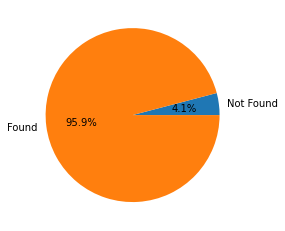

<Figure size 432x288 with 0 Axes>

In [212]:
len(namesDF.loc[namesDF['wikiPage'] == 'NaN'])/len(namesDF)*100
import matplotlib.pyplot as plt
plt.pie([len(namesDF.loc[namesDF['wikiPage'] == 'NaN']),len(namesDF)],labels = ['Not Found','Found'], autopct='%1.1f%%')


['A. Walton Litz',
 'A Dictionary of Canadianisms on Historical Principles',
 'A Dictionary of the English Language',
 'A New English Dictionary',
 'All singing, all dancing (idiom)',
 'American Civil War',
 'American English',
 'American and British English spelling differences',
 'An Anglo-Saxon Dictionary',
 'An Universal Etymological English Dictionary',
 'Annotation',
 'Antedating (lexicography)',
 'Anthony Burgess',
 'Anu Garg',
 'Appendicitis',
 'Application software',
 'Arts Council of Great Britain',
 'Australian English',
 'Australian Oxford Dictionary',
 'Balderdash and Piffle',
 'Bausch & Lomb',
 'Bible',
 'Big Ideas (TV series)',
 'Book sales club',
 'British English',
 'British Museum',
 'Broadmoor Hospital',
 'CD-ROM',
 "Cambridge Advanced Learner's Dictionary",
 'Cambridge University Press',
 'Canadian English',
 'Canadian Oxford Dictionary',
 'Canadian Press',
 'Catholicon Anglicum',
 'Century Dictionary',
 'Chambers Dictionary',
 'Charles Richardson (lexicographer)',


In [7]:
title = '9781417732470'
url = isbnAPI + title
response = urlopen(url)
data = json.loads(response.read())
data['items'][0]['volumeInfo']['authors']


['Rick Riordan']

## What might be worthwhile until I can get the library books, is a random book selector. That way I can see how efficient the code is
https://www.generatormix.com/random-book-generator
https://www.bestrandoms.com/random-book-generator

Notes
- if the isbn lookup doesnt work, then try the title lookup
    - The google books isbn api is small, try to get access to another
- Some authors don't have a wikipedia page, so we need to search for them
- Maybe if they lack a wiki article, THEN do the name search? I dunnoooooo
